In [23]:
from IPython.display import Image
from IPython.display import HTML

import pickle

In [24]:
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Executive Summary

I built a model to predict expected customer retention as well as explain which customer attributes are associated with higher retention (or higher churn).  The model predicts that 15% of the current customer base will churn over a time period of 90 days from today (January 16, 2016).  Some of the strongest findings are that customers who have `x5=91d78334` are 58% more likely to churn than the population as a whole.  On the other hand, customers with x5=de0e8ab5 are 42% more likely to be retained, however there are relatively few of these customers in the data set to draw this conclusion on.  Additionally, customers with large values of `x6` or `x7` see higher retention rates, overall.  Finally, I have identified the 100 customers who are most likely to churn in 90 days, and I recommend we target these individuals with additional promotions to keep them engaged.

## 1.  Methods

### 1.1  Pre-processing

#### 1.1.1   Database transformations
The data contain attributes (4 categorical, 4 numeric) of 10,000 customers along with their current status (active/canceled) and their signup and cancellation dates.  The data were loaded into a PostgreSQL database for ease of exploration and analysis (ETL scripts [here](https://github.com/jjardel/blog-code/tree/msh/MSH/etl)).  I computed the `days_since_signup` feature from the signup/cancellation dates plus knowledge that the "current" date is January 16, 2016.  Records having extreme values (more than 5 standard deviations from the median) for the numeric features were removed, as were records where `signup_date > cancel_date`.  The `x3` feature contains a large number of distinct values. In order to reduce noise, I removed any records that had a value for `x3` that occured fewer than 5 times in the full data set.  All told, this resulted in a loss of 249 records, but a vastly cleaner data set.  Each customer was assigned a universally unique identifier (UUID) for indexing.

#### 1.1.2.  Feature transformations
Some records contain missing values in the numeric features.  To correct for this, missing values were replaced with the mean of the feature in which they occured.  Categorical feature `x2` has many examples that are `<NA>`.  These examples were treated as a distinct group, since they may share some commonality and should not be excluded.  Aside from the outliers removed in Section 1.1.1, no additional records were removed in this step.

In order to construct a model with both categorical and numerical features, the categorical features were one-hot encoded.  This increased the number of features from 8 to 102.  (Relevant code [here](https://github.com/jjardel/blog-code/blob/msh/MSH/model/src/_churn_model.py#L59-L91)).

### 1.2  Feature Selection

In order to identify important features to use in the analysis, I built a Random Forest classifier to model customer status from the 102 features from Section 1.1.2.  I stress that this was a pre-processing step only, and this model was not used in the actual retention predictions--it would be inappropriate to train a model for prediction on such right-censored data.  

The training data was split 80/20 into a training set and an evaluation set.  Customers in the evaluation set were not used in training the model, they served to evaluate how good the model is at generalizing to unseen data.  Model hyperparameters were tuned using $k$-fold cross valdation over a grid search of possible hyperparameter values.  The $k=3$ folds were stratified in order to preserve the global ratio of active to canceled customers.

The model proved to be a good fit to the training data, and it performed well with the held-out evaluation set.  The Area Under the Receiver Operating Characteristic (ROC) curve for the held-out data is $AUROC=0.85$.  This metric was chosen for model evaluation since class labels were somewhat unbalanced. (The random forest model code is [here](https://github.com/jjardel/blog-code/blob/msh/MSH/model/src/_churn_model.py)).


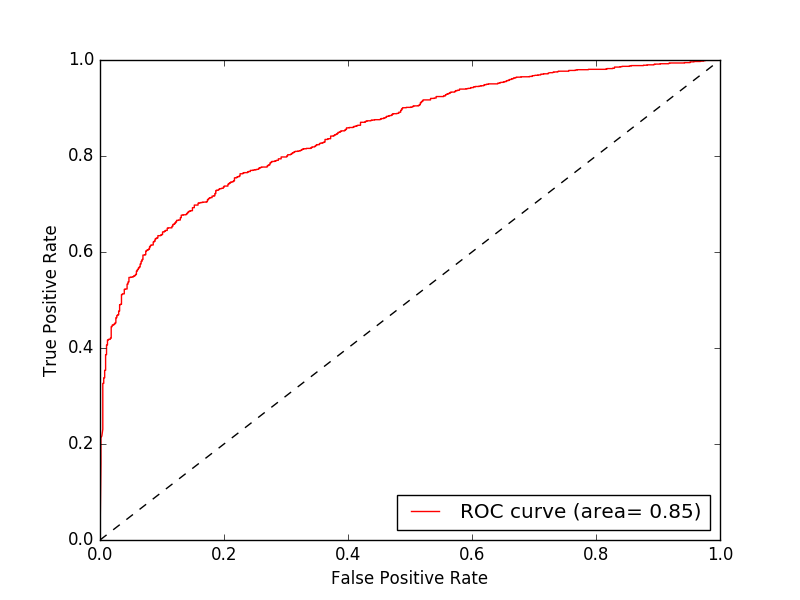

In [11]:
Image('model/output/roc_curve.png', width=600)

$\textbf{Figure 1}$--ROC curve for the model's predictions of the evaluation set (red line).  The model performs well enough and does significantly better than random chance (dashed line).

The Random Forest classifier was chosen because these models are easily interpretable.  One can examine which features were the most important in building the model (i.e. the features when split on that cause the highest information gain in the set of trees).  I recovered the top 25 most important features $X_{25}$ from the 102 input features, which I use later to build the retention model.

One drawback of this usage is that for highly correlated features, one feature is arbitrarily given all the weight while the other is given none.

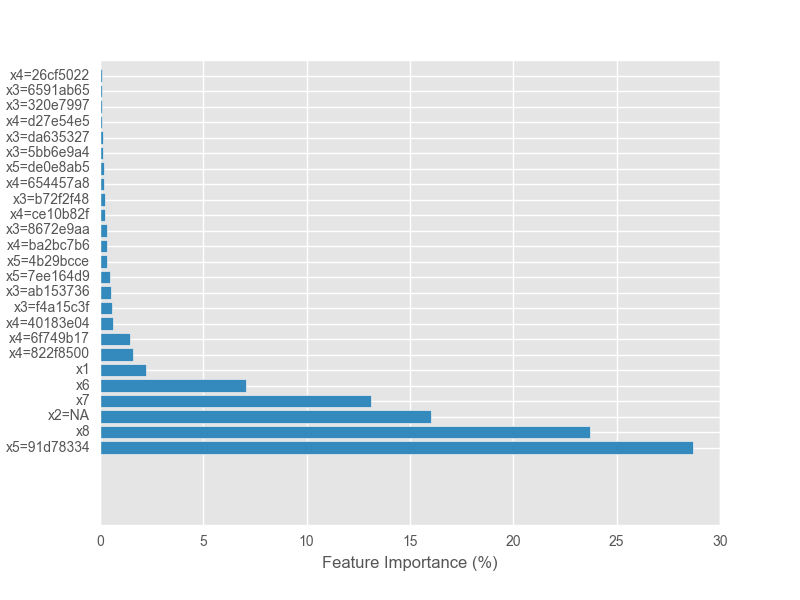

In [15]:
Image('feature_importances.png', width=600)

$\textbf{Figure 2}$--The 25 most important features according to the Random Forest Classifier. These drop off quite sharply, but at the risk of pruning features too much, I include all top 25 features in the next phase of the analysis.

The model identifies the numeric features `x1, x6, x7` and `x8` as important.  It finds the most important feature to be cases where `x5=91d78334`.  For categorical features, `x2=NA` is also important, confirming my suspicion that this class of examples shares some commonality.

###  1.3 Modeling Retention

The problem of modeling customer retention, or conversely predicting churn, is well suited to the field of Survival Analysis.  We are trying to predict future retention rates of customers from past examples of customers who have canceled the service as well as customers that are still active.  Such a problem is said to be "right-censored", meaning that we observe the cancellation events for only a fraction of the population.  If the model of Section 1.2 was blindly used to predict the label "active" or "canceled" from the training set, such a model could lead to biased conclusions.

Accordingly, I use two common techniques to account for this bias.  I use the Kaplan-Meier estimator to predict the survival function $S(t)$ of the data set (e.g. what percentage of customers remain after $t$ days), split according to the $X_{25}$ important features identified in Figure 2.  This allows broad conclusions to be made about which features contribute to churn.  Later, I use the Cox Proportional Hazards model to perform a regression of the important features against the survival curves of individual customers.  This not only allows for prediction of individual customer churn probabilities, it also lends some quantitative interpretation to how strongly each of the important features affects customer retention.

The Cox model has a regularization parameter $\lambda$.  I fit for the optimal value of $\lambda$ using $k$-fold cross validation ($k=5$) across a range of 10 possible parameter values for $\lambda$.  The best-fitting model has a concordance score of $C=0.6$  This is not the most encouraging score, so some conclusions about individual customers may not be the most accurate.  However, broad conclusions about feature influence on hazard rates should be trustworthy.

(The rest of the report draws from work done in this [Ipython Notebook](https://github.com/jjardel/blog-code/blob/msh/MSH/explore.ipynb).)

## 2.  Results

### 2.1  Features that Influence Retention Most Strongly

The Kaplan-Meier fitted survival curves (shown in Figure 3) give some insight into not only the baseline retention as a function of time, but also for how sub-populations of customers vary from this baseline.  For example, it is clear that the population having `x5=91d78334` or `x4=40183e04` churns much faster than the whole population.  Conversely, customers with `x4=6f749b17` or `x4=822f8500` are more easily retained.  Interestingly, `x2=NA`, the third-most important feature from the Random Forest model, tracks the baseline Survival curve almost identically.  Perhaps this is why this feature was given so much weight in the Random Forest model.

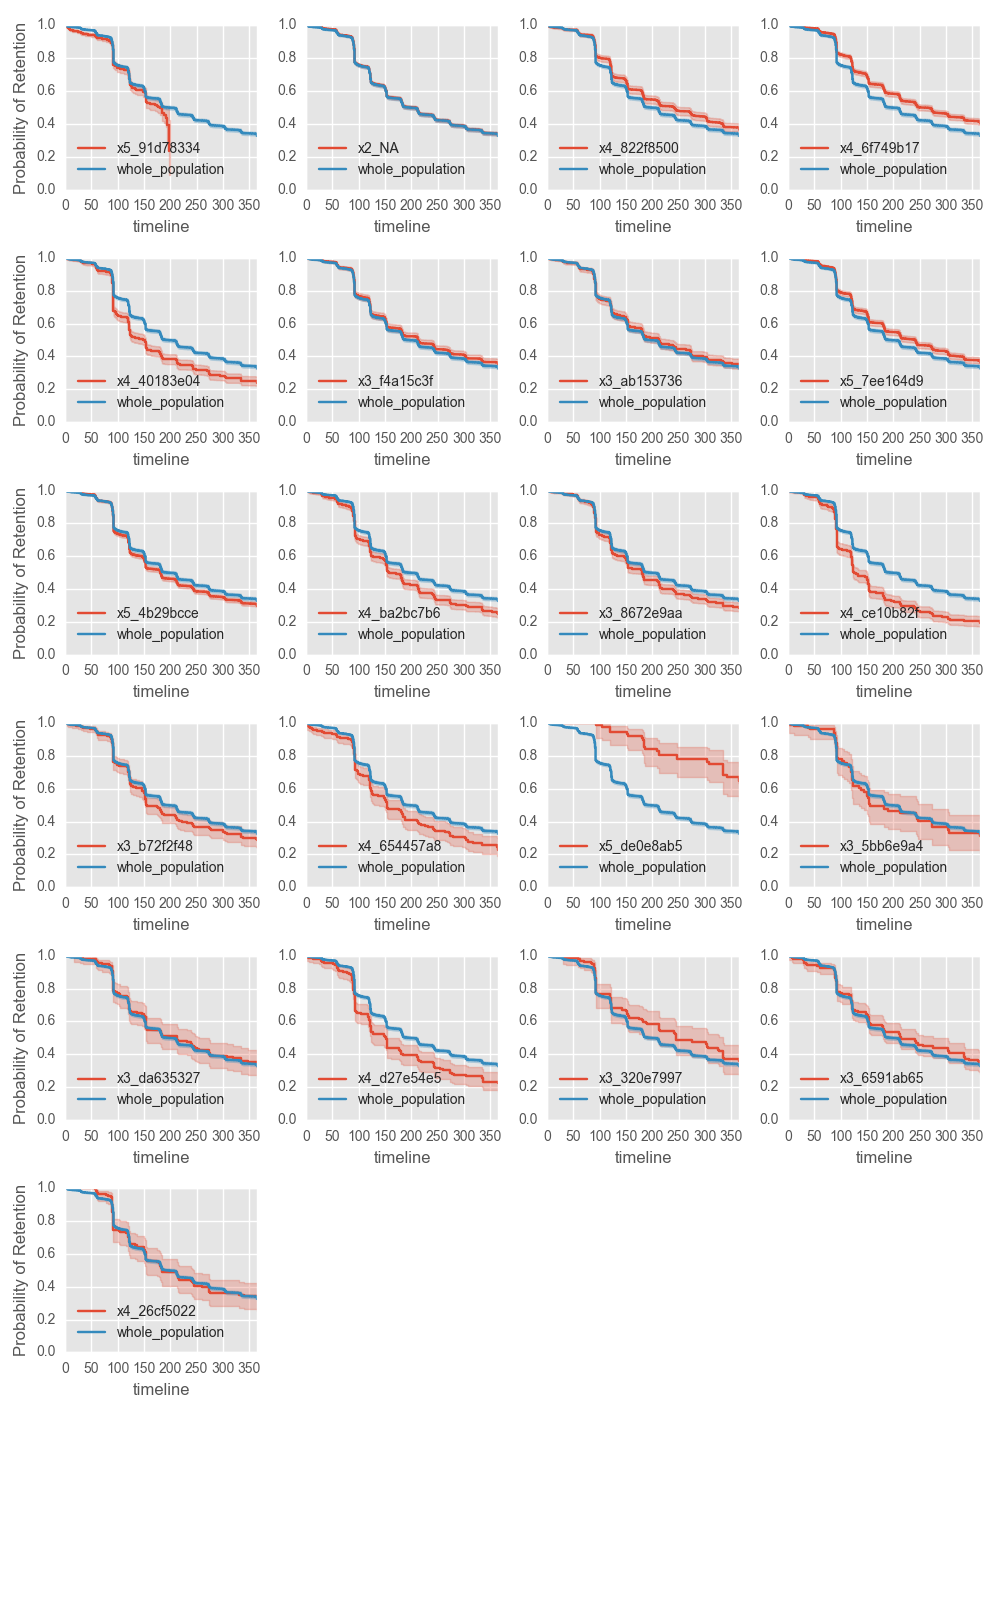

In [25]:
Image('survival_curves.png')

$\textbf{Figure 3}$-- Kaplan-Meier survival curves for subsets of the population split by the top 25 most important features.

We can speak more quantitatively about these findings by examining the results of the Cox Proportional Hazards model. This model estimates the baseline hazard function and assumes that for feature $i$, the effect this feature has on survival is proportional to $\exp{\beta_i}$--where the $\beta_i$ are the fitted regression coefficients for each feature.  Consequently, we can discuss the importance of each feature in terms of whether the model predicts coefficients that are above or below the baseline hazard.

Putting this information to use, the following conclusions are apparent: 
  - Customers who have `x5=91d78334` are 58% more likely to churn than the population as a whole.
  - Similarly, customers with `x4=40183e04` are 34% more likely to churn.
  - On the other hand, customers with x5=de0e8ab5 are 42% more likely to be retained.  However there are relatively few of these customers in the data set, so results are noisy.

We can also draw the following insights from the numerical features:
  - For every increase in x7 of 6.13, the churn rate drops by a multiplicative factor of 0.91
  - For every increase in x6 of 4.34, the churn rate drops by a multiplicative factor of 0.95
  
It should be noted that the Proportional Hazards assumption needs to be checked (i.e. is the hazard function of each feature proportional to the baseline hazard for all time).  Judging from plots in Figure 3, the answer is not always yes.  A more general model such as Aalen's Additive model could be used if the assumption is strongly violated.  However, in my opinion, the ease of interpretation of the Cox model outweighs the benefits of a more general model.

### 2.2  Predictions about Future Retention

Now that we have a model for how each feature affects the overall probability of retention for each customer, we can project the retention rate forward from the present date to make statements about what kinds of churn levels the business can expect.  In other words, we have an estimate for $P^j_{churn}(t=90)$, the probability that customer $j$ churns 90 days from now (where "now" is January 16, 2016).  For $N$ active customers each with different $P^j_{churn}(t=90)$, we can simulate $N$ Bernoulli trials to obtain the expected number of churn events.  Note this is *not* a Binomial distribution since the probabilities are different.

The results of the simulation are shown in Figure 4.  We expect 512 of the currently active customers to churn in 90 days.  The 95% credibility interval ranges from 473-550.



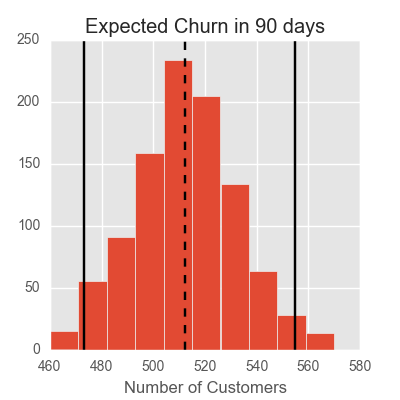

In [19]:
Image('churn_prediction.png')

$\textbf{Figure 4}$--The distribution of churn events predicted 90 days from January 16, 2016.  The dashed line shows the mean value, and the solid vertical lines show the extent of the 95% credibility interval.

Furthermore, we can identify for the Customer Success team the individuals most likely to churn in 90 days.  These customers can then receive some additional treatment to try to maximize their retention.

Table 1 shows the list of the top 100 customers most likely to cancel their subscription in 90 days.

In [21]:
with open('customers.pkl', 'rb') as fp:
    customers = pickle.load(fp)

customers

,signup_date,status,cancel_date,days_since_signup,x1,x2,x3,x4,x5,x6,x7,x8,S(t=90),S(t=0),P_churn(t=90)
customer_id,,,,,,,,,,,,,,,
b41b3bf3-2b04-43b6-b443-e22130e17162,2015-11-11,active,NaT,66,1.00,416e1394,b72f2f48,ce10b82f,91d78334,1.68,0.30,0.17,0.299016,0.878642,0.579625
0d99d436-b70e-4dc2-9c7b-efb7c0b930da,2015-11-13,active,NaT,64,1.33,416e1394,b72f2f48,ce10b82f,91d78334,0.00,0.00,0.08,0.302527,0.879133,0.576606
cb1440be-b651-41fb-a829-29db442a68da,2015-10-29,active,NaT,79,1.33,416e1394,8672e9aa,ce10b82f,91d78334,0.71,1.42,0.42,0.314609,0.873274,0.558665
1cfa29c2-d474-4a86-9ff7-dc34767a52c0,2015-10-30,active,NaT,78,1.00,fd76e8b1,31e28e8f,ce10b82f,91d78334,0.11,0.07,0.08,0.330009,0.879159,0.549150
d999672c-08b5-44c5-8983-e2feebcf857d,2015-12-07,active,NaT,40,1.00,416e1394,8672e9aa,ce10b82f,91d78334,0.11,0.05,0.33,0.401747,0.948059,0.546312
471ca2ab-741a-4f93-88fa-80de734a076a,2015-10-29,active,NaT,79,1.00,416e1394,5bb6e9a4,ce10b82f,91d78334,0.90,1.25,0.00,0.334370,0.879530,0.545159
f21c2f1d-5b55-4206-b8be-d4294093c52a,2015-11-12,active,NaT,65,1.00,416e1394,1bd0be8a,ce10b82f,91d78334,1.83,0.59,0.17,0.348299,0.892853,0.544554
1dba4ca0-f8fc-4f49-b43a-aee7ea3b1a73,2015-10-27,active,NaT,81,1.33,416e1394,0c78d5e6,ce10b82f,91d78334,0.38,0.41,0.50,0.340424,0.880614,0.540190
f4d2a8ff-b368-4f87-9a98-62ac4516798d,2015-11-02,active,NaT,75,1.33,416e1394,0c6fdf98,ce10b82f,91d78334,1.65,0.67,0.42,0.349898,0.888972,0.539074


$\textbf{Table 1}$--The 100 customers who are most likely to cancel their subscription within 90 days.  Interestingly, they all have low values for `x6` and `x7` and are almost all exclusively in the `x5=91d78334` class.

## 3.  Conclusions

It's a little difficult to recommend business actions without knowing more about the obfuscated labels for this problem.  Taken with that caveat, here are my recommendations:

 - Customers with `x5=91d78334` are the least likely to be retained long-term.  They should be targeted with additional incentives.  Or, if `x5` is not an intrinsic property of an individual, the business should work to convert customers with `x5=91d78334` into other classes of service.
 - Finance and Customer Success should plan on about 15% churn in 90 days
 - The higher `x6` and `x7` are, the more likely a customer is to be retained.  We should work to drive these up, or, if these features are an intrinsic property of the customer, target new customers with large `x6` and `x7`.  They will produce greater lifetime value.
 - The customers in Table 1 should be targeted with retention-increasing measures as they are the most likely to churn.

P.S. "purple" :)